In [30]:
import csv
import matplotlib.pyplot as plt

def calculate_roofline_points(csv_file, gpu_name):
    with open(csv_file, 'r') as file:
        csv_reader = csv.DictReader(file)

        total_flops = 0
        total_bytes = 0
        total_time = 0

        for row in csv_reader:
            flop_fadd = float(row['smsp__sass_thread_inst_executed_op_fadd_pred_on.sum'])
            flop_fmul = float(row['smsp__sass_thread_inst_executed_op_fmul_pred_on.sum'])
            flop_ffma = float(row['smsp__sass_thread_inst_executed_op_ffma_pred_on.sum'])
            dram_bytes_read = float(row['dram__bytes_read.sum'])
            dram_bytes_write = float(row['dram__bytes_write.sum'])
            time = float(row['gpu__time_duration.sum'])

            total_flops += flop_fadd + flop_fmul + 2 * flop_ffma
            total_bytes += dram_bytes_read + dram_bytes_write
            total_time += time
        arithmetic_intensity = total_flops / total_bytes
        gflops_per_sec = total_flops / total_time

        print(f"Roofline Modeling Points for {gpu_name}:")
        print(f"Total FLOPs: {total_flops}")
        print(f"Total Bytes: {total_bytes}")
        print(f"Total Time: {total_time}")
        print(f"Arithmetic Intensity: {arithmetic_intensity:.2f} FLOP/byte")
        print(f"GFLOP/s: {gflops_per_sec}")
        print()

        return (arithmetic_intensity, gflops_per_sec, gpu_name)

def plot_roofline_graph(data, peak_gflops, peak_gbps, gpu_name):
    plt.figure(figsize=(10, 8))
    plt.title(f"Roofline Model - {gpu_name}", fontsize=18)
    plt.xlabel("Arithmetic Intensity (FLOP/byte)", fontsize=14)
    plt.ylabel("Attainable FLOP/s", fontsize=14)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", color='gray', alpha=0.5)

    for ai, gflops, model in data:
        plt.scatter(ai, gflops, label=f"{model} (AI: {ai:.2f}, GFLOP/s: {gflops:.2f})", s=100)
        plt.text(ai, gflops, f' {model}', verticalalignment='bottom', horizontalalignment='right')

    # Draw the rooflines
    ai_limit = peak_gflops / peak_gbps
    x_bandwidth = [1e-2, ai_limit]
    y_bandwidth = [1e-2 * peak_gbps, ai_limit * peak_gbps]
    x_computation = [ai_limit, max([d[0] for d in data]) * 10]
    y_computation = [peak_gflops, peak_gflops]

    plt.plot(x_bandwidth, y_bandwidth, 'k--', linewidth=2, label='Peak Bandwidth (GB/s)')
    plt.plot(x_computation, y_computation, 'r--', linewidth=2, label='Peak Performance (GFLOP/s)')

    plt.legend()
    plt.tight_layout()
    plt.show()

Roofline Modeling Points for V100 - ResNet18:
Total FLOPs: 31736462994.0
Total Bytes: 1358939648.0
Total Time: 6880032.0
Arithmetic Intensity: 23.35 FLOP/byte
GFLOP/s: 4612.836538260287

Roofline Modeling Points for V100 - AlexNet:
Total FLOPs: 12439704850.0
Total Bytes: 1205831744.0
Total Time: 3039936.0
Arithmetic Intensity: 10.32 FLOP/byte
GFLOP/s: 4092.0943236962885



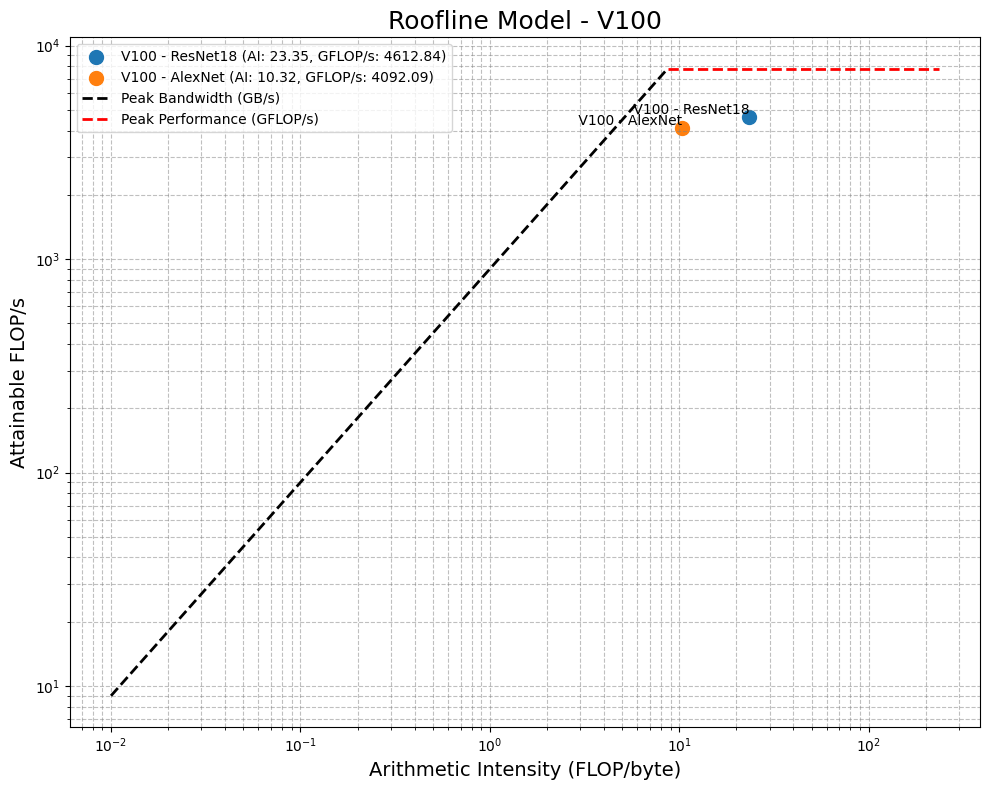

In [31]:
# V100 GPU Specifications
v100_peak_gflops = 7800
v100_peak_gbps = 900

# CSV Files
resnet18_v100_csv = 'resnet_v100_m.csv'
alexnet_v100_csv = 'alexnet_v100_m.csv'

# Calculate Roofline Modeling Points
resnet18_v100_points = calculate_roofline_points(resnet18_v100_csv, 'V100 - ResNet18')
alexnet_v100_points = calculate_roofline_points(alexnet_v100_csv, 'V100 - AlexNet')

# Plot Roofline Graphs
plot_roofline_graph([resnet18_v100_points, alexnet_v100_points], v100_peak_gflops, v100_peak_gbps, 'V100')

Roofline Modeling Points for ResNet18 on A100:
Total FLOPs: 602046738.0
Total Bytes: 928788096.0
Total Time: 4730656.0
Arithmetic Intensity: 0.65 FLOP/byte
GFLOP/s: 127.26495817916162

Roofline Modeling Points for AlexNet on A100:
Total FLOPs: 4322313522.0
Total Bytes: 825664000.0
Total Time: 2129824.0
Arithmetic Intensity: 5.23 FLOP/byte
GFLOP/s: 2029.4228640488604



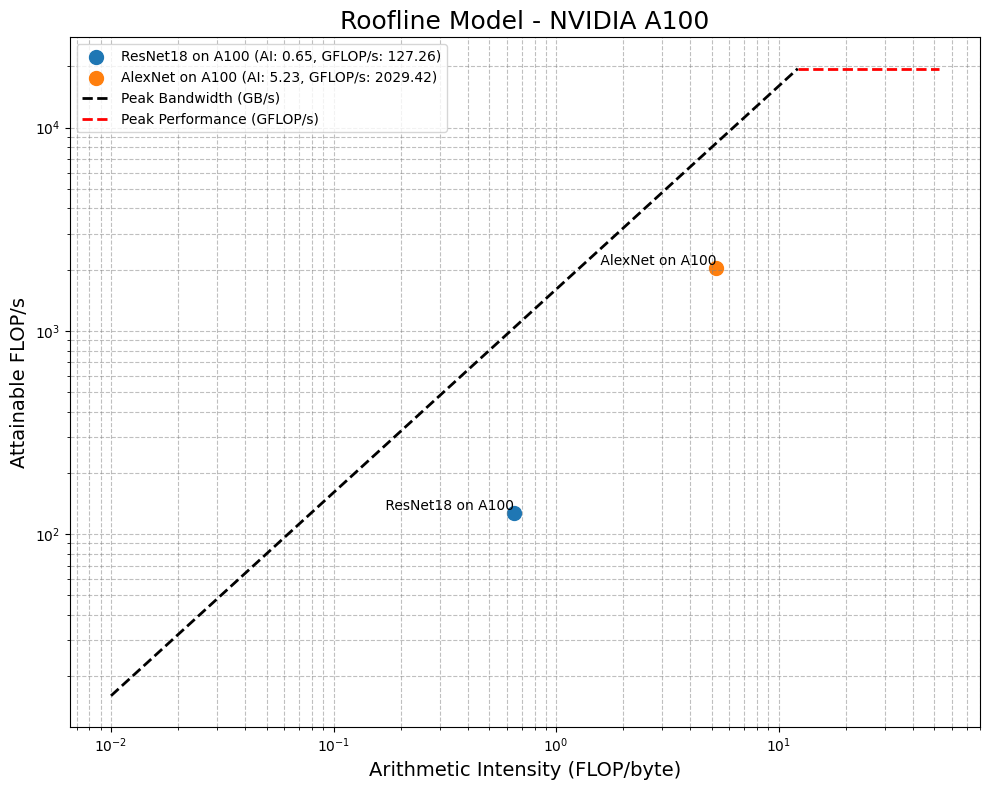

In [32]:
# A100 GPU Specifications
a100_peak_gflops = 19500
a100_peak_gbps = 1600

resnet18_a100_csv = 'resnet_a100_m.csv'
alexnet_a100_csv = 'alexnet_a100_m.csv'

# Calculate Roofline Modeling Points for each model on A100
resnet18_a100_points = calculate_roofline_points(resnet18_a100_csv, 'ResNet18 on A100')
alexnet_a100_points = calculate_roofline_points(alexnet_a100_csv, 'AlexNet on A100')

# Combine the points and the names for plotting
data_points = [(point[0], point[1], point[2]) for point in [resnet18_a100_points, alexnet_a100_points]]

# Plot Roofline Graphs for A100
plot_roofline_graph(data_points, a100_peak_gflops, a100_peak_gbps, 'NVIDIA A100')